In [ ]:
#from google.colab import drive 
#drive.mount('/content/gdrive')

In [1]:
# Import libraries required for the code

from collections import Counter
import re
import time

In [2]:
#import gensim
#import gensim.downloader as api

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from scipy.sparse import hstack
from scipy.stats import describe

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Set theme of seaborn 
sns.set()

## Load Training Data, Cross Validation Data and Testing Data

In [7]:
#Train data
train_df = pd.read_csv("new_data_train.csv", sep='\t', index_col=0)
#Validation data
test_df = pd.read_csv("new_data_test.csv", sep='\t', index_col=0)

In [8]:
train_df.head()

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,"Los Angeles, CA",...,1,0,1,2,0,0,0,0,4.0,144
6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,"Kalamazoo, MI",...,12,2,19,7,6,4,0,0,4.0,46
21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,"Los Angeles, CA",...,6,0,7,3,2,0,0,0,3.5,18
10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,"Chicago, IL",...,37,2,16,3,3,1,0,1,3.5,41
6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,"Barrington, IL",...,3,0,2,1,0,0,0,0,4.0,40


In [9]:
train_df.shape, test_df.shape

((9929, 22), (2483, 22))

In [10]:
train_df.flagged.value_counts()

0    4994
1    4935
Name: flagged, dtype: int64

In [11]:
test_df.flagged.value_counts()

1    1271
0    1212
Name: flagged, dtype: int64

In [12]:
#Check for nan

In [13]:
nan_rows = train_df[train_df['reviewContent'].isnull()]
nan_rows

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
15972,vPx7Ga3vAB7ZLfZsQChlSA,QasfZU1HgCW4LNU8AFFfwg,LMaoM2Ue2BR_HI9ba3JsZg,8/23/2012,4,0,NaN,0,Robert H.,"Denver, CO",...,84,2,16,23,6,9,1,2,4.0,1
25462,ln1j0sucN56GF7NaXqvtkQ,FezvtjI9VD4PZR0vIq-9IQ,43rd1LKcZRIunySzbMsyLQ,9/12/2007,5,0,NaN,1,Txema G.,"Chicago, IL",...,1,0,0,0,1,0,0,0,4.5,1
20728,f83DnEX60KDNk9rqInjWwg,TPOQUpDTdFMPeZwO2nOWQA,O6uWHgJzylSjWjPSJKGhnQ,12/16/2007,3,0,NaN,1,ozlem v.,"Chicago, IL",...,2,0,1,1,0,0,0,0,4.0,1


In [14]:
train_df = train_df[~train_df['reviewContent'].isnull()]
train_df

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,"Los Angeles, CA",...,1,0,1,2,0,0,0,0,4.0,144
6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,"Kalamazoo, MI",...,12,2,19,7,6,4,0,0,4.0,46
21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,"Los Angeles, CA",...,6,0,7,3,2,0,0,0,3.5,18
10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,"Chicago, IL",...,37,2,16,3,3,1,0,1,3.5,41
6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,"Barrington, IL",...,3,0,2,1,0,0,0,0,4.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,dK2U-orHZg9ps2g8BRwakA,tPufvUuxXLJOMYQ7gzsMVA,Z2nOMPedr7XYhgYhILJjEA,12/4/2011,4,1,confirming owner s helpful suggestion trick ab...,0,Andrew AndroidTopp T.,"Aurora, IL",...,518,79,538,222,258,111,16,15,4.0,83
20930,ENlbumgWkN3PE97iH7YWuQ,qKF-OwPxog4HdFuPlydllg,tW2jfL-qMccAYZSghPBbHA,1/1/2009,5,0,this best pizza chicago possibly world they am...,1,Rebecca G.,"Chicago, IL",...,3,0,2,0,0,0,0,0,4.0,46
2420,ubhEydMPnwVHLt9IpVi28w,YqVj5efZc2uGwDmgPbPWKA,Z2nOMPedr7XYhgYhILJjEA,1/6/2009,5,0,i love place great beer great service fantasti...,1,Brent C.,"Chicago, IL",...,8,0,0,0,0,0,0,0,4.0,16
3090,0NuFEa_gIMKbj0wsncFlvw,VKIlQivcuKidmmc2EXSlqA,sfWMOqUEp8S2adDeJp7Kzg,7/21/2010,4,0,i always passed place never chance come in fin...,1,Karina Kari A.,"Oak Park, IL",...,2,0,0,0,0,1,1,0,4.0,125


In [15]:
#Another row to remove
train_df.loc[17084]

reviewID             0UnEGi9_HEgRMol5WOUHMA
reviewerID           uQTZrPDE8NvAcBCOreuwhw
restaurantID         50gFzdVglOz88eFJ6v-26A
date                              11/5/2011
rating                                    4
reviewUsefulCount                         0
reviewContent                             a
flagged                                   1
name                             Belinda R.
location                        Chicago, IL
yelpJoinDate                  November 2011
friendCount                               0
reviewCount                               2
firstCount                                0
usefulCount                               0
coolCount                                 0
funnyCount                                2
complimentCount                           0
tipCount                                  0
fanCount                                  0
restaurantRating                        4.0
ReviewLength                              1
Name: 17084, dtype: object

In [16]:
train_df = train_df[train_df.index!=17084]
train_df

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,"Los Angeles, CA",...,1,0,1,2,0,0,0,0,4.0,144
6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,"Kalamazoo, MI",...,12,2,19,7,6,4,0,0,4.0,46
21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,"Los Angeles, CA",...,6,0,7,3,2,0,0,0,3.5,18
10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,"Chicago, IL",...,37,2,16,3,3,1,0,1,3.5,41
6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,"Barrington, IL",...,3,0,2,1,0,0,0,0,4.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,dK2U-orHZg9ps2g8BRwakA,tPufvUuxXLJOMYQ7gzsMVA,Z2nOMPedr7XYhgYhILJjEA,12/4/2011,4,1,confirming owner s helpful suggestion trick ab...,0,Andrew AndroidTopp T.,"Aurora, IL",...,518,79,538,222,258,111,16,15,4.0,83
20930,ENlbumgWkN3PE97iH7YWuQ,qKF-OwPxog4HdFuPlydllg,tW2jfL-qMccAYZSghPBbHA,1/1/2009,5,0,this best pizza chicago possibly world they am...,1,Rebecca G.,"Chicago, IL",...,3,0,2,0,0,0,0,0,4.0,46
2420,ubhEydMPnwVHLt9IpVi28w,YqVj5efZc2uGwDmgPbPWKA,Z2nOMPedr7XYhgYhILJjEA,1/6/2009,5,0,i love place great beer great service fantasti...,1,Brent C.,"Chicago, IL",...,8,0,0,0,0,0,0,0,4.0,16
3090,0NuFEa_gIMKbj0wsncFlvw,VKIlQivcuKidmmc2EXSlqA,sfWMOqUEp8S2adDeJp7Kzg,7/21/2010,4,0,i always passed place never chance come in fin...,1,Karina Kari A.,"Oak Park, IL",...,2,0,0,0,0,1,1,0,4.0,125


In [17]:
train_df.shape

(9925, 22)

In [18]:
test_df.shape

(2483, 22)

In [19]:
#A row to remove from test data
test_df.iloc[1091]

reviewID             YhZMfAd8yXrmErFIl-WfkQ
reviewerID           gJpqFXjZX7lpGWv6DnkGyQ
restaurantID         8d_DiHWB-pjBVW3a7D8EWg
date                               5/3/2012
rating                                    5
reviewUsefulCount                         0
reviewContent                             a
flagged                                   1
name                               Bobby M.
location               Hampshire County, WV
yelpJoinDate                     April 2012
friendCount                               0
reviewCount                               3
firstCount                                0
usefulCount                               1
coolCount                                 0
funnyCount                                0
complimentCount                           0
tipCount                                  0
fanCount                                  0
restaurantRating                        4.0
ReviewLength                              1
Name: 7120, dtype: object

In [20]:
test_df[test_df.index==7120]

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
7120,YhZMfAd8yXrmErFIl-WfkQ,gJpqFXjZX7lpGWv6DnkGyQ,8d_DiHWB-pjBVW3a7D8EWg,5/3/2012,5,0,a,1,Bobby M.,"Hampshire County, WV",...,3,0,1,0,0,0,0,0,4.0,1


In [21]:
test_df = test_df[test_df.index!=7120]
test_df

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
7267,dLS_UUea0Yh7et2YlGpUOw,hfQu0YNy_XW5oiiripgUFg,8d_DiHWB-pjBVW3a7D8EWg,1/25/2012,4,0,sunda amazing i heard many good things finally...,1,Mallory M.,"Chicago, IL",...,1,0,0,0,0,0,0,0,4.0,72
731,EDejgdY32F8Lr4ewh7FeiA,_jsZl-USMgrVVasNg50wAQ,boE4Ahsssqic7o5wQLI04w,5/5/2012,4,0,absolutely fantastic foodie community table gr...,0,Shawn K.,"Davenport, FL",...,1,0,0,0,0,0,5,0,4.0,12
9902,TRLtyGBT7VFODhxgyZ2tLA,sZxXpvmBUN2fSCtK_BZFoQ,ms5ge1XY9-Alu7HkybAMdQ,11/9/2007,3,0,i work right rarely go here they 5 personal st...,0,Dane K.,"Chicago, IL",...,845,143,2499,1451,1151,1377,2,55,3.5,102
25894,6QYZT3mkrmBmYNDUN18ILg,YMS9Fzy0OcOXFcS_qms_pg,3Mx2PM7v8qjqhgF3cDXxbQ,6/20/2011,3,0,this best big 3 brazilian steakhouses chicago ...,1,Pennywise S.,"Chicago, IL",...,2,0,0,0,0,0,0,0,4.0,30
17519,xuKTaBhJT0GaI4wRFZi6Qw,uvWWKett-BIRbvyLZXaloQ,vvhfPV-Llkd4fE2SHuLVvA,9/28/2009,4,0,i lunch the gage group 8 this first time there...,1,Rich C.,"Stoneham, MA",...,1,0,0,0,0,0,0,0,4.0,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13196,pFOs_Twh2KSxFpWh3ihaCg,t7NKOWjycGalbiIPDU2KYQ,n-mj6IJkWyCu4BuD2dvm0A,4/28/2011,5,0,there better steak chicago opinion the lobster...,1,jason s.,"Chicago, IL",...,3,0,0,0,2,0,0,0,4.0,16
10278,jXrhZUMxMDWpf9g1Yi-pDw,lbAPRUm_EfCd8pf4w8YFDw,ms5ge1XY9-Alu7HkybAMdQ,8/13/2011,4,0,it controversial topic i believe giordano s be...,1,Chris T.,"Chicago, IL",...,11,0,0,0,0,0,0,0,3.5,35
11476,zqOFLqaQxqUMt3JLEru2sQ,-R_GjIauOKiJZHyN9dDYNQ,d6UbRb9W5eA1yL-DuVZ8ug,6/13/2008,1,0,this place outrageous i went drinks girls thur...,1,Theresa H.,"Chicago, IL",...,1,0,1,0,0,0,0,0,4.0,97
24962,gLZDeE,4xHg83V-f1Q3GSaSkXMEBA,UQ3cGi3GdBljE3i2_qLcBQ,4/28/2011,4,0,ha i ve eating lunch least twice week two year...,0,Liz O.,"Chicago, IL",...,27,0,25,4,4,0,0,1,4.0,49


### Dropping Non Textual Features

In [22]:
train_df = train_df[['reviewContent','flagged']]
train_df

,reviewContent,flagged
6010,as new resident chicago los angeles i mission ...,1
6566,great place rarely wait fairly easy find parki...,0
21349,back bar makes feel though transported china s...,1
10370,hands one favorite tourist restaurants city th...,0
6011,service impeccable staff helpful owner works h...,1
...,...,...
2072,confirming owner s helpful suggestion trick ab...,0
20930,this best pizza chicago possibly world they am...,1
2420,i love place great beer great service fantasti...,1
3090,i always passed place never chance come in fin...,1


In [23]:
test_df = test_df[['reviewContent','flagged']]
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


## Defining Evaluation Metric

In [24]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [26]:
test_y = test_df.flagged
test_y

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2482, dtype: int64

## 1. Baseline Model: Predicting each value as the majority class ( genuine review )

In [27]:
train_df.flagged.value_counts()

0    4993
1    4932
Name: flagged, dtype: int64

In [28]:
#As we saw before, 0 ('genuine') is the majority class. Lets begin by predicting everything as 0 ('genuine').
preds_test = np.zeros(len(test_df))



In [29]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.48831587429492346
Precision score is: 0.0
Recall score is: 0.0
F1 score is: 0.0


In [30]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[1212    0]
 [1270    0]]


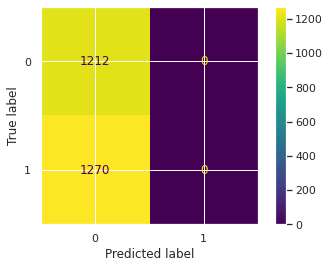

In [31]:


cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

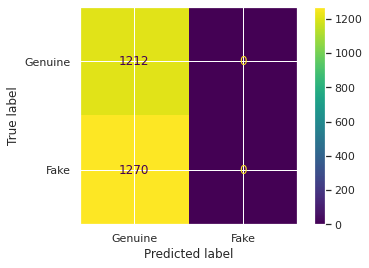

In [32]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [33]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 1270
TP: 0
TN: 1212
FP: 0


In [34]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1212
           1       0.00      0.00      0.00      1270

    accuracy                           0.49      2482
   macro avg       0.24      0.50      0.33      2482
weighted avg       0.24      0.49      0.32      2482



In [35]:
# Get baseline results
baseline_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
baseline_results

{'accuracy': 48.831587429492345, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

## 3. Featurization of Textual Sentences into Numeric Vectors

**There are three techniques we would use for vectorization:**


**1. Bag Of Words (Unigram, Bigram..)**

**2. TF-IDF**

**3. Word2Vec**

In [36]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
#Load Stopwords from NLTK. We will use these to clean our text
stop_words = set(stopwords.words("english"))

In [38]:
train_df

,reviewContent,flagged
6010,as new resident chicago los angeles i mission ...,1
6566,great place rarely wait fairly easy find parki...,0
21349,back bar makes feel though transported china s...,1
10370,hands one favorite tourist restaurants city th...,0
6011,service impeccable staff helpful owner works h...,1
...,...,...
2072,confirming owner s helpful suggestion trick ab...,0
20930,this best pizza chicago possibly world they am...,1
2420,i love place great beer great service fantasti...,1
3090,i always passed place never chance come in fin...,1


In [39]:
y_train = train_df['flagged']
y_train

6010     1
6566     0
21349    1
10370    0
6011     1
        ..
2072     0
20930    1
2420     1
3090     1
22414    0
Name: flagged, Length: 9925, dtype: int64

In [40]:
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


In [41]:
y_test = test_df['flagged']
y_test

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2482, dtype: int64

In [42]:
test_y = y_test
test_y

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2482, dtype: int64

## 3.c) Word2Vec review text

In [43]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [44]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
#Load Stopwords from NLTK. We will use these to clean our text
stop_words = set(stopwords.words("english"))

In [46]:
!pip install gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [47]:
import gensim
import gensim.downloader as api

In [48]:
gensim.__version__

'4.1.2'

In [49]:
# load pre-trained word2vec model which was trained on Google News 
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [50]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    #doc = [word for word in doc if word in model.vocab] #not working in gensim 4.0.0
    
    #changes for gensim 4.0.0
    words = list(model.index_to_key)
    doc = [word for word in doc if word in words]
    return np.mean(model[doc], axis=0)

def preprocess(text):
    # Lowercase and Tokenize
    doc = word_tokenize(text.lower())
    # Remove Stop Words
    doc = [word for word in doc if word not in stop_words]
    # Remove non-alphabet tokens
    doc = [word for word in doc if word.isalpha()]
    return doc

def to_vector(df, column):
    documents = df[column].tolist()
    corpus = [preprocess(title) for title in documents]
    X = []
    # append the vector for each document
    i=0
    for doc in corpus: 
        print(i)
        print(doc)
        vector = document_vector(model, doc)
        X.append(vector)
        i=i+1
    return np.array(X)

In [51]:
train_df.sample(10)

,reviewContent,flagged
16603,the restaurant nice the bacon cheddar hush pup...,1
20930,this best pizza chicago possibly world they am...,1
23461,great food great chef love andersonville,1
15190,great burgers huge lots choices good atmospher...,0
25282,salad bar limited great service excellent new ...,0
4071,i took out of towner friend reading many posit...,0
12747,yum shaw s great food i twice disappointed eit...,0
22064,according yelp need reservation apparently do ...,0
25120,this place amazing the service amazing the ser...,1
22594,had dried chili chicken fantastic lots heat lo...,0


In [52]:
to_vector(train_df.sample(10), "reviewContent")

0
['worst', 'service', 'long', 'time', 'better', 'service', 'taco', 'bell', 'davanti', 'enoteca', 'place', 'makes', 'great', 'traditional', 'food', 'complicated', 'messes', 'snooty', 'waitress', 'busy', 'cleaning', 'wine', 'glasses', 'bother', 'service', 'took', 'lemonade', 'return', 'refill', 'check', 'mess', 'place', 'food', 'bad', 'bad', 'pay', 'people', 'give', 'place', 'stars', 'never', 'return', 'horrible', 'food', 'worse', 'service', 'review', 'one', 'word', 'yuck']
1
['best', 'spicy', 'asian', 'food', 'ever', 'eat', 'life', 'list', 'get', 'every', 'time', 'go', 'coming', 'place', 'years', 'loving', 'every', 'time', 'remember', 'come', 'chinatown', 'food', 'service', 'stop', 'griping', 'lol', 'food', 'greater', 'service', 'spicy', 'cabbage', 'yummy', 'dry', 'chili', 'chicken', 'chef', 'favorite', 'dry', 'chili', 'prawns', 'dry', 'chili', 'shrimp', 'dont', 'like', 'shell', 'salt', 'pepper', 'scallop', 'dry', 'chili', 'pork', 'call', 'dry', 'chili', 'bacon', 'looks', 'like', 'broi

array([[-0.0170914 ,  0.04678158, -0.00835683, ..., -0.02399834,
         0.04176377, -0.01166503],
       [-0.06036116,  0.05204212,  0.04819299, ..., -0.02671788,
         0.046207  ,  0.03477739],
       [ 0.05386353, -0.1062851 , -0.00743103, ..., -0.00439453,
         0.11903381,  0.06126404],
       ...,
       [-0.00537166,  0.05101861,  0.00597579, ..., -0.03428707,
         0.0243567 ,  0.0448258 ],
       [ 0.01297037,  0.03154476, -0.01002279, ..., -0.04009973,
         0.02516174, -0.03034936],
       [-0.01911621,  0.01208801,  0.03453013, ..., -0.0419047 ,
         0.03738645, -0.037942  ]], dtype=float32)

In [53]:
to_vector(train_df.sample(10), "reviewContent").shape

0
['artopolis', 'favorite', 'chill', 'place', 'chicago', 'reminds', 'greece', 'cafe', 'fare', 'nice', 'stone', 'baked', 'pizzas', 'ice', 'coffee', 'frappe', 'recommend', 'spinach', 'pie', 'lasagna', 'special', 'wednesdays', 'well', 'rustic', 'greco', 'pizza', 'plum', 'tomatoes', 'olive', 'oil', 'crust', 'kasseri', 'feta', 'motzarrela', 'cheeses', 'nice', 'crispy', 'herb', 'crust', 'good', 'pizza', 'love', 'hummus', 'appetizer', 'along', 'greek', 'salad', 'sharing', 'pizza', 'date', 'try', 'thr', 'megas', 'oenos', 'red', 'wine', 'pizza', 'megas', 'oenos', 'means', 'big', 'one', 'greek', 'big', 'huge', 'red', 'wine', 'supple', 'tannins', 'jammy', 'fruit', 'makes', 'cheeses', 'explode', 'mouth', 'great', 'stuff', 'even', 'better', 'finish', 'wine', 'legs', 'mile', 'long', 'longer', 'foot', 'inch', 'blonde', 'dessert', 'try', 'frappe', 'iced', 'coffee', 'milk', 'medium', 'sweetness', 'awesome', 'addicting', 'drink', 'every', 'morning', 'work', 'productivity', 'roof', 'also', 'try', 'one', 

(10, 300)

In [54]:
to_vector(train_df.sample(10), "reviewContent")[0].shape

0
['best', 'burrito', 'chicago', 'hands', 'thank', 'god', 'la', 'pasadita', 'nothing', 'flour', 'tortilla', 'perfectly', 'marinated', 'meat', 'onions', 'cilantro', 'like', 'sour', 'cream', 'bullshit', 'like', 'beans', 'corn', 'veggies', 'love']
1
['groupon', 'worth', 'made', 'easy', 'come', 'chose', 'course', 'option', 'brought', 'bottle', 'red', 'bottle', 'white', 'menu', 'started', 'amuse', 'piece', 'yellowtail', 'good', 'nothing', 'amazing', 'means', 'first', 'course', 'seafood', 'salad', 'octopus', 'lobster', 'octopus', 'tender', 'expecting', 'figured', 'chewy', 'pickled', 'veggies', 'plate', 'second', 'course', 'motoyakil', 'omg', 'easily', 'best', 'thing', 'ate', 'night', 'sure', 'horrible', 'scallop', 'mayo', 'sauce', 'incredible', 'could', 'eaten', 'third', 'course', 'potato', 'vichyssoise', 'mushrooms', 'umami', 'really', 'good', 'husband', 'really', 'enjoyed', 'course', 'umami', 'ness', 'fourth', 'course', 'barramundi', 'need', 'start', 'buying', 'fish', 'awesome', 'came', 'c

(300,)

In [55]:
#Apply on full train data

X_train = to_vector(train_df, "reviewContent")

Streaming output truncated to the last 5000 lines.
7425
['friend', 'decided', 'try', 'sunda', 'brunch', 'excellent', 'choice', 'sunda', 'dim', 'sum', 'dark', 'familiar', 'atmosphere', 'food', 'brunch', 'munched', 'southeastern', 'chop', 'chop', 'salad', 'crispy', 'salmon', 'salad', 'tempura', 'shrimp', 'rolls', 'divine', 'greatest', 'treat', 'strawberry', 'passionfruit', 'mimosa', 'ashamed', 'write', 'um', 'long', 'week']
7426
['taste', 'chicago', 'review', 'eaten', 'restaurant', 'born', 'bred', 'chicagoan', 'sampled', 'many', 'brazilian', 'steakhouses', 'elsewhere', 'makes', 'sense', 'restaurant', 'would', 'serve', 'sub', 'par', 'meal', 'one', 'received', 'taste', 'opening', 'day', 'friday', 'taste', 'way', 'introduce', 'group', 'people', 'either', 'never', 'heard', 'get', 'establishment', 'great', 'way', 'drive', 'future', 'business', 'knowing', 'would', 'tdb', 'present', 'platter', 'meats', 'poorly', 'beef', 'picanha', 'charcoal', 'size', 'taste', 'color', 'inedible', 'chicken', 'br

In [56]:
#Apply on full test data

X_test = to_vector(test_df, "reviewContent")

0
['sunda', 'amazing', 'heard', 'many', 'good', 'things', 'finally', 'got', 'experience', 'weeks', 'ago', 'first', 'time', 'really', 'enjoyed', 'crispy', 'brussel', 'sprout', 'salad', 'something', 'probably', 'tried', 'sushi', 'great', 'course', 'tail', 'two', 'tunas', 'favorite', 'know', 'spicy', 'tuna', 'classic', 'places', 'get', 'right', 'sunda', 'roll', 'came', 'guacamole', 'something', 'overwhelming', 'many', 'tastes', 'heavy', 'sushi', 'roll', 'complaint', 'night', 'went', 'dessert', 'completed', 'evening', 'something', 'weird', 'name', 'none', 'less', 'awesome', 'carrot', 'cake', 'dessert']
1
['absolutely', 'fantastic', 'foodie', 'community', 'table', 'great', 'single', 'diner', 'small', 'plates', 'reasonable', 'priced']
2
['work', 'right', 'rarely', 'go', 'personal', 'stuffed', 'pizzas', 'lunch', 'ok', 'even', 'close', 'good', 'real', 'deal', 'full', 'size', 'stuffed', 'pizza', 'ask', 'real', 'deal', 'stuffed', 'pizza', 'exciting', 'btw', 'giordano', 'deep', 'dish', 'pizza', '

In [57]:
X_train

array([[-0.01212951,  0.04253823,  0.03994587, ..., -0.06833234,
         0.05961772,  0.00121743],
       [ 0.02072577,  0.01913968, -0.00064334, ..., -0.060857  ,
         0.03569154, -0.01052444],
       [-0.0109787 ,  0.03770828,  0.02054977, ..., -0.06298447,
         0.07049942, -0.01732635],
       ...,
       [-0.02882603,  0.01372419,  0.01814052, ..., -0.07160296,
        -0.01161848, -0.07672991],
       [-0.03564309,  0.01950003,  0.02971883, ..., -0.09759755,
         0.04447034,  0.00445821],
       [-0.02186056,  0.07561786,  0.07403447, ..., -0.04175223,
         0.05688125, -0.02341872]], dtype=float32)

In [58]:
len(X_train) #no of rows

9925

In [59]:
len(X_train[0]) #no of features

300

In [60]:
len(X_test) #no of rows

2482

In [61]:
len(X_train[0]) #no of features

300

In [ ]:
#saving vectorized train dataframe
X_train_df = pd.DataFrame(X_train)
X_train_df.to_csv('X_train_word2vec.csv', index=False, header=False)

In [ ]:
#saving vectorized test dataframe
X_test_df = pd.DataFrame(X_test)
X_test_df.to_csv('X_test_word2vec.csv', index=False, header=False)

## 4. Model Building

In [62]:
model_results = {}

In [63]:
#Add Baseline
model_results["BASELINE"] = baseline_results

In [64]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0}}

### a) Logistic Regression

In [65]:
lr = LogisticRegression(max_iter=7600,random_state = 1)
_ = lr.fit(X_train, y_train)

#predictions on test data
preds_test= lr.predict(X_test)

In [66]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6430298146655923
Precision score is: 0.6649484536082474
Recall score is: 0.6094488188976378
F1 score is: 0.6359901396877568


In [67]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[822 390]
 [496 774]]


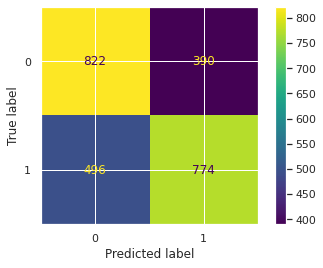

In [68]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

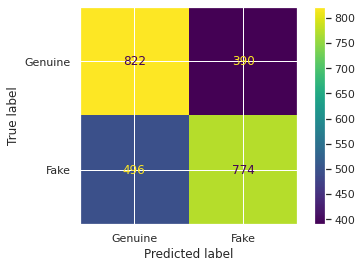

In [69]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [70]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 496
TP: 774
TN: 822
FP: 390


In [71]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65      1212
           1       0.66      0.61      0.64      1270

    accuracy                           0.64      2482
   macro avg       0.64      0.64      0.64      2482
weighted avg       0.64      0.64      0.64      2482



In [72]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6438333203399079


In [73]:
# Get baseline results
lr_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
lr_results

{'accuracy': 64.30298146655923,
 'precision': 0.6649484536082474,
 'recall': 0.6094488188976378,
 'f1': 0.6359901396877568}

In [74]:
model_results["Logistic Regression"] = lr_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568}}

### b) Decision Tree Classifier

In [75]:
dt = DecisionTreeClassifier(random_state = 1)
_ = dt.fit(X_train, y_train)

#predictions on test data
preds_test= dt.predict(X_test)


In [76]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5628525382755842
Precision score is: 0.5745366639806607
Recall score is: 0.5614173228346456
F1 score is: 0.5679012345679012


In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[684 528]
 [557 713]]


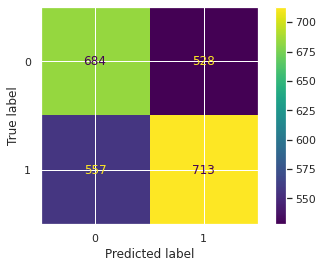

In [ ]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

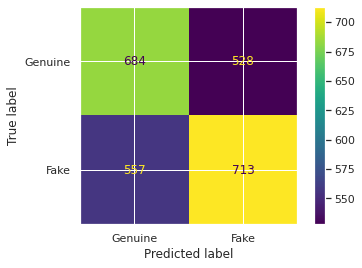

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [ ]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 557
TP: 713
TN: 684
FP: 528


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      1212
           1       0.57      0.56      0.57      1270

    accuracy                           0.56      2482
   macro avg       0.56      0.56      0.56      2482
weighted avg       0.56      0.56      0.56      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5628868792391051


In [ ]:
# Get baseline results
dt_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
dt_results

{'accuracy': 56.28525382755842,
 'precision': 0.5745366639806607,
 'recall': 0.5614173228346456,
 'f1': 0.5679012345679012}

In [ ]:
model_results["Decision Tree"] = dt_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012}}

We will now try to do some hyperparameter tuning on Decision Tree

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

dt2 = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=30, n_jobs=-1)

search = dt2.fit(X_train, y_train)

search.best_params_

{'min_samples_split': 20,
 'max_leaf_nodes': 8,
 'max_features': 0.4,
 'max_depth': 8,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 2}}

In [ ]:
optimal_params = search.best_params_
optimal_params

{'min_samples_split': 20,
 'max_leaf_nodes': 8,
 'max_features': 0.4,
 'max_depth': 8,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 2}}

In [ ]:
dt2 = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = dt2.fit(X_train, y_train)


#predictions on test data
preds_test= dt2.predict(X_test)

In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5745366639806607
Precision score is: 0.5499067164179104
Recall score is: 0.9283464566929134
F1 score is: 0.6906854130052724


In [ ]:
#We increased Recall at the cost of Precision ( FN decreased but FP increased)

In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 247  965]
 [  91 1179]]


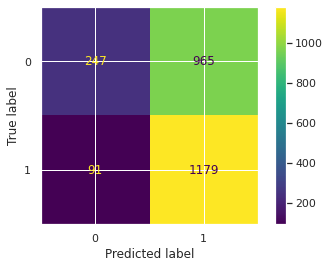

In [ ]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

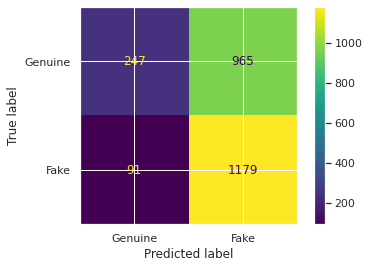

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [ ]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 91
TP: 1179
TN: 247
FP: 965


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.73      0.20      0.32      1212
           1       0.55      0.93      0.69      1270

    accuracy                           0.57      2482
   macro avg       0.64      0.57      0.50      2482
weighted avg       0.64      0.57      0.51      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5660709181154335


In [ ]:
# Get baseline results
dt_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
dt_results

{'accuracy': 57.45366639806607,
 'precision': 0.5499067164179104,
 'recall': 0.9283464566929134,
 'f1': 0.6906854130052724}

In [ ]:
model_results["Decision Tree Tuned"] = dt_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724}}

c) Random Forest Classifier

In [ ]:
#creation of random forrest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1) #by default no of estimators=10
rf.fit(X_train, y_train)

#predictions on test data
preds_test= rf.predict(X_test)

In [ ]:
#f1 score on test set
f1_score(y_test, preds_test)

0.6520231213872831

In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6361804995970991
Precision score is: 0.6384905660377358
Recall score is: 0.6661417322834645
F1 score is: 0.6520231213872831


In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[733 479]
 [424 846]]


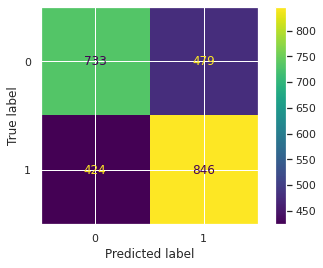

In [ ]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

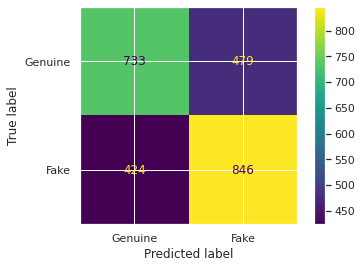

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [ ]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 424
TP: 846
TN: 733
FP: 479


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.63      0.60      0.62      1212
           1       0.64      0.67      0.65      1270

    accuracy                           0.64      2482
   macro avg       0.64      0.64      0.64      2482
weighted avg       0.64      0.64      0.64      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6354636054156597


In [ ]:
# Get baseline results
rf_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
rf_results

{'accuracy': 63.61804995970991,
 'precision': 0.6384905660377358,
 'recall': 0.6661417322834645,
 'f1': 0.6520231213872831}

In [ ]:
model_results["Random Forest"] = rf_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724},
 'Random Forest': {'accuracy': 63.61804995970991,
  'precision': 0.6384905660377358,
  'recall': 0.6661417322834645,
  'f1': 0.6520231213872831}}

In [ ]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

rf2 = RandomizedSearchCV(RandomForestClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=30, n_jobs=-1)

search = rf2.fit(X_train, y_train)

search.best_params_

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [ ]:
optimal_params = search.best_params_
optimal_params

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [ ]:
rf2 = RandomForestClassifier(random_state = 1, **optimal_params)
_ = rf2.fit(X_train, y_train)

#predictions on test data
preds_test= rf2.predict(X_test)



In [ ]:
#f1 score on test set
f1_score(y_test, preds_test)

0.6967091609842869

In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5878323932312651
Precision score is: 0.5587256300523062
Recall score is: 0.9251968503937008
F1 score is: 0.6967091609842869


In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 284  928]
 [  95 1175]]


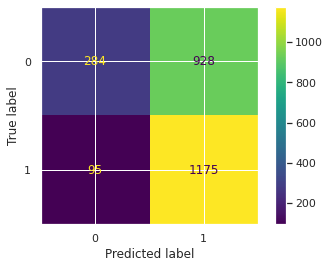

In [ ]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

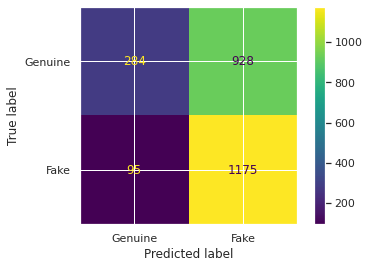

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [ ]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 95
TP: 1175
TN: 284
FP: 928


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.75      0.23      0.36      1212
           1       0.56      0.93      0.70      1270

    accuracy                           0.59      2482
   macro avg       0.65      0.58      0.53      2482
weighted avg       0.65      0.59      0.53      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5797601413684675


In [ ]:
# Get baseline results
rf_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
rf_results

{'accuracy': 58.783239323126516,
 'precision': 0.5587256300523062,
 'recall': 0.9251968503937008,
 'f1': 0.6967091609842869}

In [ ]:
model_results["Random Forest Tuned"] = rf_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724},
 'Random Forest': {'accuracy': 63.61804995970991,
  'precision': 0.6384905660377358,
  'recall': 0.6661417322834645,
  'f1': 0.6520231213872831},
 'Random Forest Tuned': {'accuracy': 58.783239323126516,
  'precision': 0.5587256300523062,
  'recall': 0.9251968503937008,
  'f1': 0.6967091609842869}}

In [ ]:
'''
#Visualizing Feature Importance
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), trn[features].columns.values) #trn.columns has list of all columns in our training data
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rf2)    
'''

'\n#Visualizing Feature Importance\ndef plot_feature_importances(model):\n    n_features = X_train.shape[1]\n    plt.figure(figsize=(12,12))\n    plt.barh(range(n_features), model.feature_importances_, align=\'center\') \n    plt.yticks(np.arange(n_features), trn[features].columns.values) #trn.columns has list of all columns in our training data\n    plt.xlabel("Feature importance")\n    plt.ylabel("Feature")\n\nplot_feature_importances(rf2)    \n'

### d) Support Vector Machines

In [ ]:
from sklearn.svm import SVC

svc = SVC(random_state = 1)
_ = svc.fit(X_train, y_train)

#predictions on test data
preds_test= svc.predict(X_test)

In [ ]:
#f1 score on test set
f1_score(y_test, preds_test)

0.6461538461538462

In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6478646253021757
Precision score is: 0.665
Recall score is: 0.6283464566929133
F1 score is: 0.6461538461538462


In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[810 402]
 [472 798]]


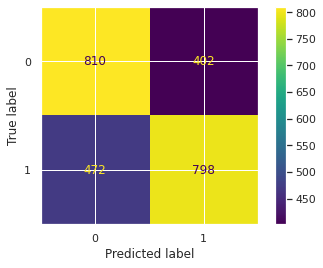

In [ ]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

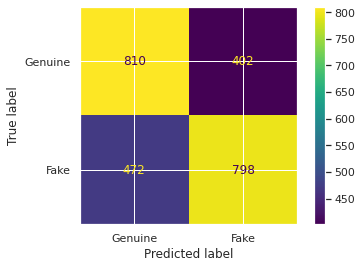

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [ ]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 472
TP: 798
TN: 810
FP: 402


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1212
           1       0.67      0.63      0.65      1270

    accuracy                           0.65      2482
   macro avg       0.65      0.65      0.65      2482
weighted avg       0.65      0.65      0.65      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6483316441880408


In [ ]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 64.78646253021758,
 'precision': 0.665,
 'recall': 0.6283464566929133,
 'f1': 0.6461538461538462}

In [ ]:
model_results["SVC"] = svc_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724},
 'Random Forest': {'accuracy': 63.61804995970991,
  'precision': 0.6384905660377358,
  'recall': 0.6661417322834645,
  'f1': 0.6520231213872831},
 'Random Forest Tuned': {'accuracy': 58.783239323126516,
  'precision': 0.5587256300523062,
  'recall': 0.9251968503937008,
  'f1': 0.6967091609842869},
 'SVC': {'accuracy': 64.78646253021758,
  'precision': 0.665,
  'recall': 0.6283464566929133,
  'f1': 0.6461538461538462}}

In [ ]:
#current parameters
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
#Now we will do tuning of the hyper-parameters

In [ ]:
# List of C values
C_range = np.logspace(-10, 10, 21)
print(f'The list of values for C are {C_range}')

# List of gamma values
gamma_range = np.logspace(-10, 10, 21)
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09
 1.e+10]
The list of values for gamma are [1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09
 1.e+10]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the search space

hyperparam_combs = {
    
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
}


svc2 = RandomizedSearchCV(SVC(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=10)

search = svc2.fit(X_train, y_train)

search.best_params_

In [ ]:
optimal_params = search.best_params_
optimal_params

In [ ]:
svc2 = SVC(random_state = 1, **optimal_params)
_ = svc2.fit(X_train, y_train)

#predictions on test data
preds_test= svc2.predict(X_test)



In [ ]:
#f1 score on test set
f1_score(y_test, preds_test)

0.7056808449900085

In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5847764800644382
Precision score is: 0.553763440860215
Recall score is: 0.9724626278520849
F1 score is: 0.7056808449900085


In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 216  996]
 [  35 1236]]


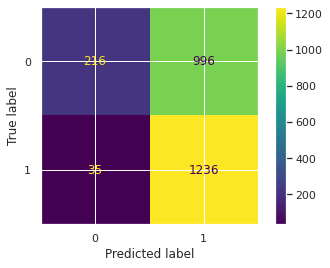

In [ ]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

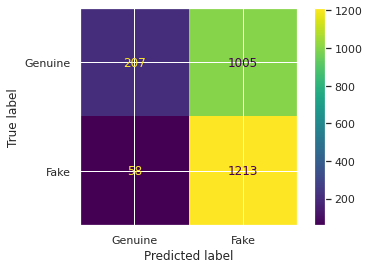

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [ ]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 35
TP: 1236
TN: 216
FP: 996


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.86      0.18      0.30      1212
           1       0.55      0.97      0.71      1271

    accuracy                           0.58      2483
   macro avg       0.71      0.58      0.50      2483
weighted avg       0.70      0.58      0.51      2483



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5753402248171315


In [ ]:
# Get baseline results
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 58.477648006443815,
 'precision': 0.553763440860215,
 'recall': 0.9724626278520849,
 'f1': 0.7056808449900085}

In [ ]:
model_results["SVC Tuned"] = 

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Logistic Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Decision Tree': {'accuracy': 58.840112766814336,
  'precision': 0.5985748218527316,
  'recall': 0.5948072383949646,
  'f1': 0.5966850828729282},
 'Decision Tree Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085},
 'Random Forest Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085}}

### Support Vector Machines: Other Variants

In [ ]:
from sklearn.svm import LinearSVC, NuSVC, SVC

#### 1. Linear SVC

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state = 1)
_ = svc.fit(X_train, y_train)

In [ ]:
#predictions on test data
preds_test= svc.predict(X_test)

In [ ]:
# Tuning on C hyperparameter
for c in range(1, 21, 1):
    c = c / 10
    svc = LinearSVC(random_state = 1, C=c)
    _ = svc.fit(X_train, y_train)
    preds_test= svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    print(c, f1_value)

0.1 0.6308835672997521
0.2 0.6317525773195877
0.3 0.6296296296296297
0.4 0.6305863058630586
0.5 0.6320947325438955
0.6 0.6335099877700774
0.7 0.632952691680261
0.8 0.6302486750917243
0.9 0.6299469604243166
1.0 0.628524724152023
1.1 0.6276116345759933
1.2 0.6273546273546273
1.3 0.6279164961113386
1.4 0.626792298238427
1.5 0.6254098360655738
1.6 0.6254604993860008
1.7 0.6254604993860008
1.8 0.6246418338108883
1.9 0.6246418338108883
2.0 0.6242821985233798


In [ ]:
lin_svc = LinearSVC(random_state=1, C=0.6)
lin_svc = lin_svc.fit(X_train, y_train)

In [ ]:
#predictions on test data
preds_test= lin_svc.predict(X_test)

In [ ]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6335099877700774


In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6377921031426269
Precision score is: 0.6568047337278107
Recall score is: 0.6118110236220472
F1 score is: 0.6335099877700774


Confusion Matrix is:
[[806 406]
 [493 777]]


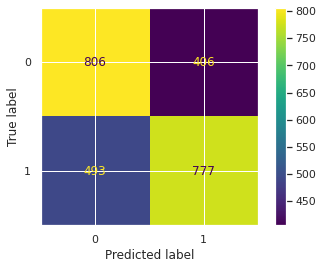

In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      1212
           1       0.66      0.61      0.63      1270

    accuracy                           0.64      2482
   macro avg       0.64      0.64      0.64      2482
weighted avg       0.64      0.64      0.64      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6384137626361062


In [ ]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 63.77921031426269,
 'precision': 0.6568047337278107,
 'recall': 0.6118110236220472,
 'f1': 0.6335099877700774}

In [ ]:
model_results["Linear SVC Tuned"] = svc_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724},
 'Random Forest': {'accuracy': 63.61804995970991,
  'precision': 0.6384905660377358,
  'recall': 0.6661417322834645,
  'f1': 0.6520231213872831},
 'Random Forest Tuned': {'accuracy': 58.783239323126516,
  'precision': 0.5587256300523062,
  'recall': 0.9251968503937008,
  'f1': 0.6967091609842869},
 'SVC': {'accuracy': 64.78646253021758,
  'precision': 0.665,
  'recall': 0.6283464566929133,
  'f1': 0.6461538461538462},
 'Linear SVC Tuned': {'accuracy

#### 2. NuSVR

In [ ]:
nu_svc = NuSVC()
nu_svc = nu_svc.fit(X_train, y_train)

In [ ]:
#predictions on test data
preds_test= nu_svc.predict(X_test)

In [ ]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6320560362587556


In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6402095084609186
Precision score is: 0.6629213483146067
Recall score is: 0.6039370078740157
F1 score is: 0.6320560362587556


Confusion Matrix is:
[[822 390]
 [503 767]]


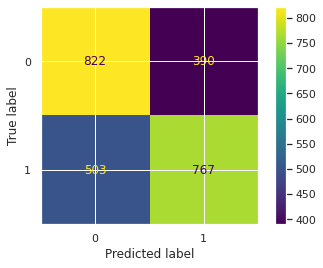

In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65      1212
           1       0.66      0.60      0.63      1270

    accuracy                           0.64      2482
   macro avg       0.64      0.64      0.64      2482
weighted avg       0.64      0.64      0.64      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.641077414828097


In [ ]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 64.02095084609186,
 'precision': 0.6629213483146067,
 'recall': 0.6039370078740157,
 'f1': 0.6320560362587556}

In [ ]:
model_results["Nu SVC"] = svc_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724},
 'Random Forest': {'accuracy': 63.61804995970991,
  'precision': 0.6384905660377358,
  'recall': 0.6661417322834645,
  'f1': 0.6520231213872831},
 'Random Forest Tuned': {'accuracy': 58.783239323126516,
  'precision': 0.5587256300523062,
  'recall': 0.9251968503937008,
  'f1': 0.6967091609842869},
 'SVC': {'accuracy': 64.78646253021758,
  'precision': 0.665,
  'recall': 0.6283464566929133,
  'f1': 0.6461538461538462},
 'Linear SVC Tuned': {'accuracy

In [ ]:
# Tuning on the type of kernel for NuSVC
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    nu_svc = NuSVC(random_state = 1, kernel=kernel)
    nu_svc = nu_svc.fit(X_train, y_train)
    preds_test= nu_svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    print(kernel, f1_value)

linear 0.6065808297567954
poly 0.6210084033613446
rbf 0.6320560362587556
sigmoid 0.5307941653160454


In [ ]:
nu_svc = NuSVC(random_state = 1, kernel='rbf') #same kernel as default 
nu_svc = nu_svc.fit(X_train, y_train)

In [ ]:
#predictions on test data
preds_test= nu_svc.predict(X_test)

In [ ]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)

In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6402095084609186
Precision score is: 0.6629213483146067
Recall score is: 0.6039370078740157
F1 score is: 0.6320560362587556


Confusion Matrix is:
[[822 390]
 [503 767]]


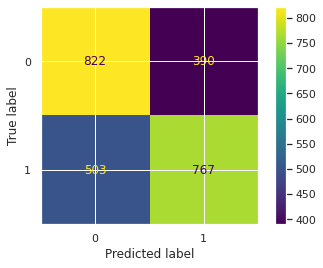

In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65      1212
           1       0.66      0.60      0.63      1270

    accuracy                           0.64      2482
   macro avg       0.64      0.64      0.64      2482
weighted avg       0.64      0.64      0.64      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.641077414828097


In [ ]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 64.02095084609186,
 'precision': 0.6629213483146067,
 'recall': 0.6039370078740157,
 'f1': 0.6320560362587556}

In [ ]:
model_results["Nu SVC Tuned"] = svc_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724},
 'Random Forest': {'accuracy': 63.61804995970991,
  'precision': 0.6384905660377358,
  'recall': 0.6661417322834645,
  'f1': 0.6520231213872831},
 'Random Forest Tuned': {'accuracy': 58.783239323126516,
  'precision': 0.5587256300523062,
  'recall': 0.9251968503937008,
  'f1': 0.6967091609842869},
 'SVC': {'accuracy': 64.78646253021758,
  'precision': 0.665,
  'recall': 0.6283464566929133,
  'f1': 0.6461538461538462},
 'Linear SVC Tuned': {'accuracy

#### 3. RBF-Kernel SVR

In [ ]:
rbf_svc = SVC(kernel='rbf')
rbf_svc.fit(X_train, y_train)

SVC()

In [ ]:
#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [ ]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6461538461538462


In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6478646253021757
Precision score is: 0.665
Recall score is: 0.6283464566929133
F1 score is: 0.6461538461538462


Confusion Matrix is:
[[810 402]
 [472 798]]


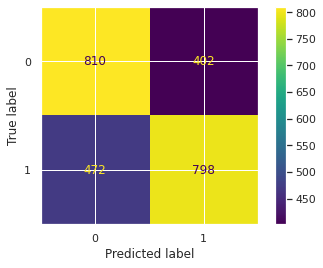

In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1212
           1       0.67      0.63      0.65      1270

    accuracy                           0.65      2482
   macro avg       0.65      0.65      0.65      2482
weighted avg       0.65      0.65      0.65      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6483316441880408


In [ ]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 64.78646253021758,
 'precision': 0.665,
 'recall': 0.6283464566929133,
 'f1': 0.6461538461538462}

In [ ]:
model_results["RBF Kernel SVC"] = svc_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724},
 'Random Forest': {'accuracy': 63.61804995970991,
  'precision': 0.6384905660377358,
  'recall': 0.6661417322834645,
  'f1': 0.6520231213872831},
 'Random Forest Tuned': {'accuracy': 58.783239323126516,
  'precision': 0.5587256300523062,
  'recall': 0.9251968503937008,
  'f1': 0.6967091609842869},
 'SVC': {'accuracy': 64.78646253021758,
  'precision': 0.665,
  'recall': 0.6283464566929133,
  'f1': 0.6461538461538462},
 'Linear SVC Tuned': {'accuracy

**Now we will tune the 'C' parameter for RBF Kernel SVC.**

In [ ]:
svc_rbf_c_results = {}

In [ ]:
for c in range(2, 41, 2):
    c = c / 10
    rbf_svc = SVC(kernel="rbf",C=c)
    rbf_svc = rbf_svc.fit(X_train, y_train)

    #predictions on test data
    preds_test= rbf_svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    #print(f1_value)
    
    svc_rbf_c_results[c] = f1_value
    print(c, f1_value)

0.2 0.6337280522662312
0.4 0.6425376169174462
0.6 0.6450829623634156
0.8 0.6505246166263116
1.0 0.6461538461538462
1.2 0.6470113085621972
1.4 0.644822006472492
1.6 0.6423948220064725
1.8 0.6418755052546484
2.0 0.6399026763990268
2.2 0.6412955465587045
2.4 0.6399026763990268
2.6 0.6396103896103895
2.8 0.6420454545454545
3.0 0.6431181485992692
3.2 0.6406186406186407
3.4 0.6400326131267835
3.6 0.6397388820889434
3.8 0.6394112837285364
4.0 0.6382978723404255


In [ ]:
sorted(svc_rbf_c_results.items(), key=lambda x: x[1])[-1]

(0.8, 0.6505246166263116)

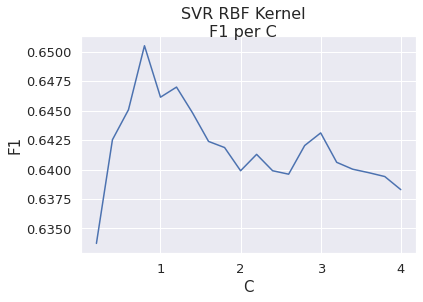

In [ ]:
svc_rbf_c_results_df = (
    pd.DataFrame(svc_rbf_c_results.items(), columns=["C", "F1"])
    .sort_values("C")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="C", y="F1", data=svc_rbf_c_results_df, color="b")
plt.suptitle("SVR RBF Kernel\nF1 per C", fontsize=16)
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("F1", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

#### SVM Model with best hyperparameters:

In [ ]:
rbf_svc = SVC(kernel="rbf",C=0.8)
rbf_svc = rbf_svc.fit(X_train, y_train)

#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [ ]:
#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [ ]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6505246166263116


In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6510878323932313
Precision score is: 0.6672185430463576
Recall score is: 0.6346456692913386
F1 score is: 0.6505246166263116


Confusion Matrix is:
[[810 402]
 [464 806]]


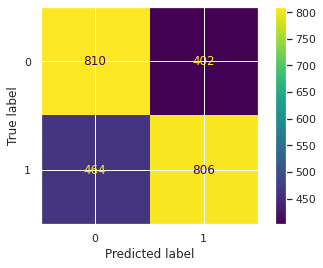

In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      1212
           1       0.67      0.63      0.65      1270

    accuracy                           0.65      2482
   macro avg       0.65      0.65      0.65      2482
weighted avg       0.65      0.65      0.65      2482



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6514812504872535


In [ ]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 65.10878323932313,
 'precision': 0.6672185430463576,
 'recall': 0.6346456692913386,
 'f1': 0.6505246166263116}

In [ ]:
model_results["RBF Kernel SVC Tuned"] = svc_results

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'Decision Tree': {'accuracy': 56.28525382755842,
  'precision': 0.5745366639806607,
  'recall': 0.5614173228346456,
  'f1': 0.5679012345679012},
 'Decision Tree Tuned': {'accuracy': 57.45366639806607,
  'precision': 0.5499067164179104,
  'recall': 0.9283464566929134,
  'f1': 0.6906854130052724},
 'Random Forest': {'accuracy': 63.61804995970991,
  'precision': 0.6384905660377358,
  'recall': 0.6661417322834645,
  'f1': 0.6520231213872831},
 'Random Forest Tuned': {'accuracy': 58.783239323126516,
  'precision': 0.5587256300523062,
  'recall': 0.9251968503937008,
  'f1': 0.6967091609842869},
 'SVC': {'accuracy': 64.78646253021758,
  'precision': 0.665,
  'recall': 0.6283464566929133,
  'f1': 0.6461538461538462},
 'Linear SVC Tuned': {'accuracy

### e) XGBoost Model

In [77]:
import xgboost as xgb

In [78]:
# define model
xgb = xgb.XGBClassifier()
xgb = xgb.fit(X_train, y_train)

In [79]:
#predictions on test data
preds_test= xgb.predict(X_test)

In [80]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6439454691259022


In [81]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6422240128928284
Precision score is: 0.6560457516339869
Recall score is: 0.6322834645669292
F1 score is: 0.6439454691259022


Confusion Matrix is:
[[791 421]
 [467 803]]


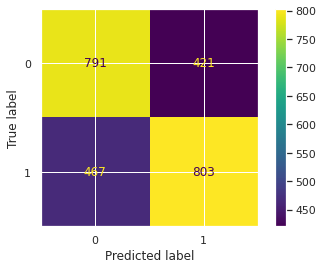

In [82]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [83]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1212
           1       0.66      0.63      0.64      1270

    accuracy                           0.64      2482
   macro avg       0.64      0.64      0.64      2482
weighted avg       0.64      0.64      0.64      2482



In [84]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.642461864296666


In [85]:
xgb_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
xgb_results

{'accuracy': 64.22240128928284,
 'precision': 0.6560457516339869,
 'recall': 0.6322834645669292,
 'f1': 0.6439454691259022}

In [87]:
model_results["XGBoost"] = xgb_results

In [88]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'XGBoost': {'accuracy': 64.22240128928284,
  'precision': 0.6560457516339869,
  'recall': 0.6322834645669292,
  'f1': 0.6439454691259022}}

In [92]:
#Hyper-parameter Tuning on XGBoost

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbc = xgb.XGBClassifier(seed = 20)

clf = RandomizedSearchCV(estimator=xgbc,
                         param_distributions=params,
                         scoring='f1',
                         n_iter=10,
                         verbose=1, n_jobs=-1)


clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(seed=20), n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='f1', verbose=1)

In [93]:
print("Best parameters:", clf.best_params_)
print("Highest F1: ", (clf.best_score_))

Best parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.6}
Highest F1:  0.6538629848839917


In [106]:
# define best model
xgb_tuned = xgb.XGBClassifier(subsample= 0.6, n_estimators= 1000, max_depth= 6, learning_rate= 0.01, colsample_bytree= 0.7, colsample_bylevel= 0.6)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(colsample_bylevel=0.6, colsample_bytree=0.7, learning_rate=0.01,
              max_depth=6, n_estimators=1000, subsample=0.6)

In [107]:
#predictions on test data
preds_test= xgb_tuned.predict(X_test)

In [108]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6617532971295578


In [95]:
# define best model
xgb_tuned = xgb.XGBClassifier(subsample= 0.7, n_estimators= 100, max_depth= 15, learning_rate= 0.1, colsample_bytree= 0.9, colsample_bylevel= 0.6)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(colsample_bylevel=0.6, colsample_bytree=0.9, max_depth=15,
              subsample=0.7)

In [109]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6486704270749396
Precision score is: 0.6521406727828746
Recall score is: 0.6716535433070866
F1 score is: 0.6617532971295578


Confusion Matrix is:
[[757 455]
 [417 853]]


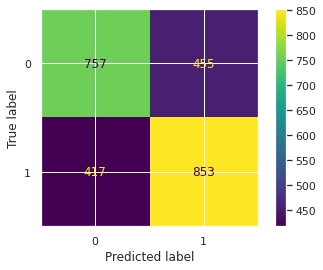

In [110]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [111]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1212
           1       0.65      0.67      0.66      1270

    accuracy                           0.65      2482
   macro avg       0.65      0.65      0.65      2482
weighted avg       0.65      0.65      0.65      2482



In [112]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6481205010264807


In [113]:
xgb_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
xgb_results

{'accuracy': 64.86704270749397,
 'precision': 0.6521406727828746,
 'recall': 0.6716535433070866,
 'f1': 0.6617532971295578}

In [114]:
model_results["XGBoost Tuned"] = xgb_results

In [115]:
model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'XGBoost': {'accuracy': 64.22240128928284,
  'precision': 0.6560457516339869,
  'recall': 0.6322834645669292,
  'f1': 0.6439454691259022},
 'XGBoost Tuned': {'accuracy': 64.86704270749397,
  'precision': 0.6521406727828746,
  'recall': 0.6716535433070866,
  'f1': 0.6617532971295578}}

### f) Stacking Classifier Model

In [119]:
from sklearn.ensemble import StackingClassifier


level0 = list()
level0.append(('rbf-svc-tuned',SVC(kernel="rbf",C=0.8)))
level0.append(('random-forest', RandomForestClassifier(random_state=1)))
level0.append(('xgb', xgb.XGBClassifier(subsample= 0.6, n_estimators= 1000, max_depth= 6, learning_rate= 0.01, colsample_bytree= 0.7, colsample_bylevel= 0.6)))

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# fit the model on all available data
model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rbf-svc-tuned', SVC(C=0.8)),
                               ('random-forest',
                                RandomForestClassifier(random_state=1)),
                               ('xgb',
                                XGBClassifier(colsample_bylevel=0.6,
                                              colsample_bytree=0.7,
                                              learning_rate=0.01, max_depth=6,
                                              n_estimators=1000,
                                              subsample=0.6))],
                   final_estimator=LogisticRegression())

In [121]:
#predictions on test data
preds_test= model.predict(X_test)

#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6600946372239748


In [122]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6526994359387591
Precision score is: 0.6611374407582938
Recall score is: 0.6590551181102362
F1 score is: 0.6600946372239748


Confusion Matrix is:
[[776 436]
 [346 925]]


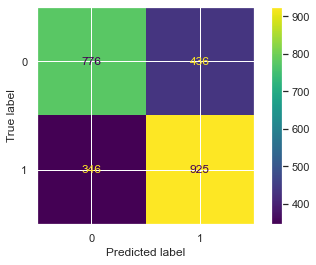

In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [123]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)

# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1212
           1       0.66      0.66      0.66      1270

    accuracy                           0.65      2482
   macro avg       0.65      0.65      0.65      2482
weighted avg       0.65      0.65      0.65      2482



In [124]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))



AUC on Test data is 0.6525473610353162


In [125]:
stacking_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
stacking_results



{'accuracy': 65.26994359387591,
 'precision': 0.6611374407582938,
 'recall': 0.6590551181102362,
 'f1': 0.6600946372239748}

In [126]:
model_results["Stacking"] = stacking_results

model_results

{'BASELINE': {'accuracy': 48.831587429492345,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 64.30298146655923,
  'precision': 0.6649484536082474,
  'recall': 0.6094488188976378,
  'f1': 0.6359901396877568},
 'XGBoost': {'accuracy': 64.22240128928284,
  'precision': 0.6560457516339869,
  'recall': 0.6322834645669292,
  'f1': 0.6439454691259022},
 'XGBoost Tuned': {'accuracy': 64.86704270749397,
  'precision': 0.6521406727828746,
  'recall': 0.6716535433070866,
  'f1': 0.6617532971295578},
 'Stacking': {'accuracy': 65.26994359387591,
  'precision': 0.6611374407582938,
  'recall': 0.6590551181102362,
  'f1': 0.6600946372239748}}

In [ ]:
#If precision is more important, XGBoost is better
#If recall is more important, Stacking is better

In [127]:
preds_test

array([0, 1, 0, ..., 1, 0, 1])

In [128]:
y_test

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2482, dtype: int64

In [129]:
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


In [130]:
# Saving Results to a CSV
def preds_to_csv(df, predictions, file_name="output.csv"):
    final_df = pd.DataFrame(df)
    final_df["pred"] = predictions
    final_df.to_csv(file_name, index=False)
    return f"Final Predictions saved to: {file_name}"

In [131]:
preds_to_csv(test_df, preds_test,"word2vec-output.csv")

'Final Predictions saved to: word2vec-output.csv'